In [2]:
# Authors: Bellet, Gramfort, Salmon
from math import sqrt
import numpy as np
from scipy.sparse.linalg import svds
from scipy.linalg import svd
from sklearn.metrics.pairwise import rbf_kernel


def rank_trunc(gram_mat, k, fast=True):
    """
    k-th order approximation of the Gram Matrix G.

    Parameters
    ----------
    gram_mat : array, shape (n_samples, n_samples)
        the Gram matrix
    k : int
        the order approximation
    fast : bool
        use svd (if False) or svds (if True).

    Return
    ------
    gram_mat_k : array, shape (n_samples, n_samples)
        The rank k Gram matrix.
    """
    if fast:
        u,s,v=svds(gram_mat,k)
        #pass  # TODO
    else:
        U,S,V=svd(gram_mat) #full by default--> both U,V: [nxn] here
        s=S[:k]
        u=U[:k,:k]
        v=V[:k,:k]
        #pass  # TODO
    gram_mat_k = (u.dot(np.diag(s))).dot(v)
    return gram_mat_k, u, s


def random_features(X_train, X_test, gamma, c=300, seed=44):
    """Compute random kernel features

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    # TODO Question 4
    [n1,p]=X_train.shape
    n2=X_test.shape[0]
    # p iid Gaussian vectors 
    W=sqrt(2.*gamma)*rng.randn(p,c)
    # uniformly distributed phases in [0,2\pi)
    b=rng.uniform(0,2*np.pi,size=c)
    X_new_train = sqrt(2./c)*np.cos(X_train.dot(W)+np.outer(np.ones(n1),b))
    X_new_test = sqrt(2./c)*np.cos(X_test.dot(W)+np.outer(np.ones(n2),b))
    
    return X_new_train, X_new_test


def nystrom(X_train, X_test, gamma, c=500, k=200, seed=44):
    """Compute nystrom kernel approximation

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of points to sample for the approximation
    k : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    # TODO Question 6
    [n1,p] = X_train.shape
    n2 = X_test.shape[0]

    I=rng.randint(n1,size=c)
    G=rbf_kernel(X_train[I],X_train[I])
    Gk,uk,sk=rank_trunc(G,k) #fast: by default True
    Mk= uk.dot(np.diag(np.sqrt(1./sk)))

    Ttr = rbf_kernel(X_train, X_train[I])
    Tte = rbf_kernel(X_test,X_train[I])
    X_new_train =  Ttr.dot(Mk)
    X_new_test = Tte.dot(Mk)

    return X_new_train, X_new_test
########################################  TP SCRIPT  ###################################

from time import time
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets.mldata import fetch_mldata

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
plt.style.use('ggplot')

####################################################################
# Download the data (if not present); load it as numpy arrays
dataset_name = 'covtype.binary'
covtype = fetch_mldata(dataset_name)
covtype.data = covtype.data.toarray()  # convert to dense

####################################################################
# Extract features
X_train, X_test, y_train, y_test = \
    train_test_split(covtype.data[:50000, :], covtype.target[:50000],
                     train_size=10000, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

####################################################################
# SVM classfication (Question 1)

from sklearn.svm import SVC, LinearSVC

print("Fitting SVC rbf on %d samples..." % X_train.shape[0])
t0 = time()
# TODO
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC rbf on %d samples..." % X_test.shape[0])
t1 = time()
# TODO
accuracy_kernel=clf.score(X_test,y_test)
print("done in %0.3fs" % (time() - t1))
timing_kernel = time() - t0
print("classification accuracy: %0.3f" % accuracy_kernel)
print'timing_kernel: ',str(timing_kernel)

# TODO with LinearSVC
print("Fitting SVC linear on %d samples..." % X_train.shape[0])
t0 = time()
# TODO
clf = LinearSVC(dual=False)
clf.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC linear on %d samples..." % X_test.shape[0])
t1 = time()
# TODO
accuracy_kernel=clf.score(X_test,y_test)
print("done in %0.3fs" % (time() - t1))
timing_linear = time() - t0
print("classification accuracy: %0.3f" % accuracy_kernel)
print'timing_linear: ',str(timing_linear)


Fitting SVC rbf on 10000 samples...
done in 3.986s
Predicting with SVC rbf on 40000 samples...
done in 9.203s
classification accuracy: 0.875
timing_kernel:  13.1896529198
Fitting SVC linear on 10000 samples...
done in 0.191s
Predicting with SVC linear on 40000 samples...
done in 0.005s
classification accuracy: 0.863
timing_linear:  0.196995973587


done q23


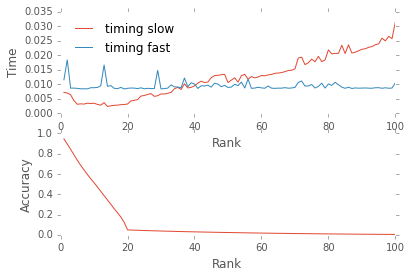

In [5]:
%matplotlib inline
####################################################################
# Gram approximation
# from TP_kernel_approx_source import rank_trunc, nystrom, random_features

p = 200
r_noise = 100
r_signal = 20

intensity = 50

rng = np.random.RandomState(42)
X_noise = rng.randn(r_noise, p)
X_signal = rng.randn(r_signal, p)

gram_signal = np.dot(X_noise.T, X_noise) + intensity * np.dot(X_signal.T,
                                                              X_signal)
n_ranks = 100
ranks = np.arange(1, n_ranks + 1)
timing_fast = np.zeros(n_ranks)
timing_slow = np.zeros(n_ranks)
accuracy = np.zeros(n_ranks)

# TODO : Question 2 Implement rank_trunc function in source file.
# TODO : Question 3 Evaluate accuracy with Frobenius norm as a function
# of the rank for both svd solvers

# Use linalg.norm(A, 'fro') to compute Frobenius norm of A
for k, rank in enumerate(ranks):
    tf=time()
    gk,_,_=rank_trunc(gram_signal,rank)
    timing_fast[k]=time()-tf
    tsl=time()
    gks,_,_=rank_trunc(gram_signal,rank,fast=False)
    timing_slow[k]=time()-tsl
    accuracy[k]= linalg.norm(gram_signal-gk,ord='fro')/linalg.norm(gram_signal,ord='fro')
#    accuracy[k]= linalg.norm(gram_signal-gks,ord='fro')/linalg.norm(gram_signal,ord='fro')

print("done q23")
#plt.plot(accuracy,'o-')
#plt.title('Accuracy of approximasion by truncated SVD as a function of rank')
#plt.figure(2)
#plt.plot(ts,'o-')
#plt.title('Computation time using fast/slow truncSVD as a function of rank')

#plt.savefig('q2.png')
####################################################################
# Display
opt={'figroot':'figs/'}

fig, axes = plt.subplots(ncols=1, nrows=2)
ax1, ax2 = axes.ravel()

ax1.plot(ranks, timing_fast, '-')
ax1.plot(ranks, timing_slow, '-')

ax1.set_xlabel('Rank')
ax1.set_ylabel('Time')
ax1.legend({'timing fast','timing slow'},loc=2)
ax2.plot(ranks, accuracy, '-')
ax2.set_xlabel('Rank')
ax2.set_ylabel('Accuracy')
# plt.tight_layout()
plt.savefig(opt['figroot']+'q23-new.png')
plt.show()

$\textbf{Questions 2-3}$

In the implementation $\texttt{rank_trunc}$, two options are given:

   (1) Fast option uses the imported function $\texttt{svds}$ that only calculates the first $k$ largest singular values and the corresponding orthogonal matrices $U_k, U_k^{\top}$ (particularily for positive semi-definite matrices, the SVD is equivalent to ..., thus V = V^{\top}) 
    
   (2) Slow option calculates by default the full matrices for the SVD of G, in which the imported function $\texttt{svd}$ gives out these full matrices, we just need to truncate out the first $k\times k$ blocs to compute our approximation $$\tilde{G}_k=U_k\Sigma_k U_k^{\top},$$ where $U_k=\texttt{U[:k,:k]}$ and $\Sigma_k=\texttt{np.diag(S[:k]))}$.  
   
   The curve for the two options' computation time correspond well to their respective computational strategies: fast always compute k-singular values, modulo some critical/interesting points that makes the computation fluctuate, the time generally remains constante and will be faster than the slow-option after a certain value of $k$.
   The critical/interesting points on which the computation time fluctuates are the same in both cases and they are related to the specific nature of the traning set (for example, the geometrical manifold characteristics related to clustering).


%The Nystrom approximation consists of doing .... $$F(k) = \int_{-\infty}^{\infty} f(x) e^{2\pi i k} dx$$

In [7]:
####################################################################
# Random Kernel Features:

n_samples, n_features = X_train.shape
n_samples_test, _ = X_test.shape
gamma = 1. / n_features

# TODO : Question 4 Implement random features in source file.

Z_train, Z_test = random_features(X_train, X_test, gamma, c=300, seed=44)

# TODO : Question 5 Estimate training, testing time and accuracy
print("Fitting SVC linear on %d samples..." % n_samples)
t0 = time()
# TODO
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("Q5-train done in %0.3fs" % (time() - t0))

print("Predicting with SVC rbf on %d samples..." % n_samples_test)
t1 = time()
# TODO
accuracy_kernel=clf.score(Z_test,y_test)
print("prediction done in %0.3fs" % (time() - t1))
timing_q5 = time() - t0
print("classification accuracy: %0.3f" % accuracy_kernel)
print'Q5-training-testing time: ',str(timing_q5)


Fitting SVC linear on 10000 samples...
Q5-train done in 1.005s
Predicting with SVC rbf on 40000 samples...
done in 0.022s
classification accuracy: 0.875
Q5-training-testing time:  1.02740812302


Questions 4-5:

  We can see that the computation time (for training and prediction on the same datasets) is very close to that of the linear SVM on raw data, thus it is greatly reduced compared to the time used for RBF-kernel SVM; on the other hand, the test score is at least as good as that of the RBF-kernel SVM trained on original data (which outperforms the first linear-svm's score by $\sim 1\%$).

In [8]:
####################################################################
# SVM Nystrom:

# TODO : Question 6-7 Implement nystrom in source file.

Z_train, Z_test = nystrom(X_train, X_test, gamma, c=500, k=200, seed=44)

print("Fitting SVC linear on %d samples..." % n_samples)
t0 = time()
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t1 = time()
accuracy = clf.score(Z_test, y_test)
print("done in %0.3fs" % (time() - t1))
print("classification accuracy: %0.3f" % accuracy)
print'Q7-training-testing time: ',str(timing_q5)


Fitting SVC linear on 10000 samples...
done in 0.724s
Predicting with SVC linear on 40000 samples...
done in 0.015s
classification accuracy: 0.879


Questions 6-7:
    
       we 